In [1]:
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.random import choice
import copy
from matplotlib import cm
import matplotlib
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML  # for embedded matplotlib animation
from math import *
import queue

matplotlib.rc('animation', html='html5')

In [2]:
# GLobal variables

global GRID_SIZE, PHEROMONE_STRENGTH, PHEROMONE_FADE, ANT_VALUE, FOOD_SOURCE_VALUE, N_WORK, N_SEARCH

GRID_SIZE =10
PHEROMONE_STRENGTH = 1
PHEROMONE_FADE = 0.0001 
ANT_VALUE = 5 
FOOD_SOURCE_VALUE = 1000 
N_WORK = 5 
N_SEARCH =1

In [55]:
class Ant:
    
    def __init__(self, kind, create_location):
        self.location = create_location
        self.origin = create_location
        
        # Queue to keep track of the steps an ant needs to make
        self.nextSteps = queue.Queue()
        self.kind = kind
    
    def getKind(self):
        return self.kind
        
    def changeLocation(self, coord):
        self.location = coord
        
    def getLocation(self):
        return self.location
        
    def changeOrigin(self, coord):
        self.origin = coord
        
    def getOrigin(self):
        return self.origin
        
    def addNextStep(self, nextCoord):
        self.nextSteps.put(nextCoord)
    
    # nextSteps.get removes the first element from the queue and returns it.
    # Therefore, when a step gets made it gets automatically removed from the queue
    def setStep(self):
        step = self.nextSteps.get()
        self.location = step
        
    def noNextSteps(self):
        return self.nextSteps.empty()

        
    def findShortestPath(self, targetCoord, origin):
        x = origin[0]
        y = origin[1]

        x_new = x
        y_new = y

        x_target = targetCoord[0]
        y_target = targetCoord[1]

        dx = x_target - x
        dy = y_target - y

        # Three possibilities: ant is on the same x or y coordinate, in which case it
        # can walk back in a straight line.
        # Or the x-distance is the same as the y-distance, in whcih case the ant can 
        # walk back in diagonal line.
        # Else, the ant should walk back in a partly diagonal, partly straight line.
        l = []

        while x != x_target or y != y_target:
            if x == x_target:
                y_new += dy / np.abs(dy)
                self.nextSteps.put((x_new, y_new))
                y = y_new
                continue

            if np.abs(dx) == np.abs(dy):
                x_new += dx / np.abs(dx)
                y_new += dx / np.abs(dy)
                self.nextSteps.put((x_new, y_new))
                x = x_new
                y = y_new
                continue

            while y != y_target:
                x_new += dx / np.abs(dx)
                y_new += dy / np.abs(dy)
                self.nextSteps.put((x_new, y_new))
                x = x_new
                y = y_new
                
            x_new += dx / np.abs(dx)
            self.nextSteps.put((x_new, y_new))
            x = x_new
        

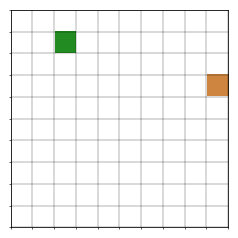

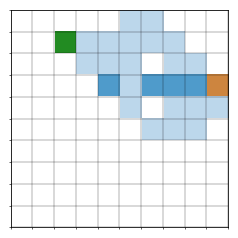

In [82]:
class Grid:
    
    # para([Grid size, pheromone strength, pheromone fade, n_search, n_work])
    # de n_work en n_search worden later toegevoegd wegens errors
    def __init__(self, para):
        # Create board of specifc board size 
        self.grid = np.zeros((para[0], para[0]), dtype=float)
        
        self.grid_no_ants = self.grid
        self.grid_size = para[0]
        self.nest_value = 25
        self.food_source_value = 1000
        self.ant_value = 5
        self.pheromone_strength = para[1]
        self.pheromone_fade = para[2]
        self.n_work = para[3]
        self.n_search = para[4]
        self.ant_dict = {}
        
        self.ants = []
        
        self.nest_location = None
        self.food_location = {}
        self.total_cost = 0
        self.cost_per_step = 0.1
        self.return_reward = 1
        self.food_reward = 2*self.cost_per_step * (para[0]-1) +1
        self.return_reward = 0
        

    # Get neighbour xy coordinates as tuple  
    def check_neighbours(self, coord, grid_size):
        # Initalize variables
        neighbours = []

        # List of relative position for all possible neighbours of a coordinate
        adj = [(-1, 1), (0, 1), (1, 1), (-1, 0), (1, 0), (-1, -1), (0,-1), (1,-1)]

        # Create list of all possible nieghbours
        for n in adj:
            neighbours.append(tuple(np.subtract(coord, n)))

        # In case of corners and edge pieces: find all neighbours that exist but are not valid for the specific 
        # board
        neigh = []
        for n_tup in neighbours:
            if n_tup[0] < 0 or n_tup[1] < 0:
                neigh.append(n_tup)
            elif n_tup[0] >= grid_size or n_tup[1] >= grid_size:
                neigh.append(n_tup)

        # Remove the found none valid neighbours 
        for i in neigh:
            neighbours.remove(i)

        # Return list of neighbours as tuple
        return neighbours

    # change value at specific cell, returns new grid
    def change_cell_value(self, coord, new_value):
        self.grid[int(coord[1])][int(coord[0])] = new_value
        return self.grid
    
    def get_ants(self):
        return self.ants
    
    # return which value a cell has
    def get_kind(self, coord):
        x = int(coord[0])
        y = int(coord[1])
        return self.grid[y, x]
    
    # sets the new value of a cell
    def setKind(self, coord, value):
        x = int(coord[0])
        y = int(coord[1])
        if value is not 5 and value is not 25 and value < 100:
            return "Invalid value"
        self.grid[y, x] = value
        
    def setNestLocation(self, coord):
        x = int(coord[0])
        y = int(coord[1])
        self.nest_location = (x,y)
        self.setKind(coord, self.nest_value)

    def setFoodSource(self, coord, amtFood):
        x = int(coord[0])
        y = int(coord[1])
        self.setKind(coord, self.food_source_value)
        self.food_location[coord] = amtFood

    def addPheromone(self, coord):
        x = int(coord[0])
        y = int(coord[1])
        if coord not in self.food_location.keys() and coord != self.nest_location:
            self.grid[y, x] += self.pheromone_strength
            self.grid_no_ants[y, x] += self.pheromone_strength

    def pheromoneFade(self, coord):
        # The cell must already have pheromones
        x = int(coord[0])
        y = int(coord[1])
        '''
        # reaction-diffusion-type simulation (Moore neighbours)
        surroundPhero = 0
        for i in self.check_neighbours(coord, self.grid_size):
            if 0 <= self.get_kind(i) <= 1:
                surroundPhero += self.get_kind(i) 
        new_value = (self.get_kind((x, y)) * (1 - 8* self.pheromone_fade) + self.pheromone_fade*surroundPhero)
        self.grid[y, x] -= self.pheromone_strength 
        self.grid[y, x] += new_value
        self.grid_no_ants[y, x] -= self.pheromone_strength 
        self.grid_no_ants[y, x] += new_value
        '''
        
        self.grid[y,x] -= self.pheromone_fade
        self.grid_no_ants[y,x] -= self.pheromone_fade

    def retrieveFood(self, coord):
        # The cell must be of the kind food source
        x = int(coord[0])
        y = int(coord[1])
        self.grid[y, x] -= self.food_value;
    
        
    def possible_steps_list(self, coord, origin):
        pn = self.check_neighbours(coord, self.grid_size)
        dist = self.origin_distance(coord, origin)
        
        best_neigh = []
        for n in pn:
            distance = self.origin_distance(n, origin)
            if distance > dist:
                best_neigh.append(n)
        
        return best_neigh
        
    def decide_step_worker(self, coord, origin):
        possible_steps = self.possible_steps_list(coord, origin)
        pos_step = []
        pos_step_sum = 0
        
        for p in possible_steps:
            if 0 < self.get_kind(p) <= 1:
                pos_step.append(p)
                pos_step_sum += self.get_kind(p)
                
        probability_distribution = []
        
        for pos in pos_step:
            self.get_kind(pos)
            probability_distribution.append(self.get_kind(pos)/pos_step_sum)
        
        if pos_step == []:
            pos_step = possible_steps
            prob_value = 1/len(possible_steps)
            probability_distribution = [prob_value]*len(possible_steps)
        
        [index] = choice(range(len(pos_step)), 1, p=probability_distribution)

        return pos_step[index]
    
    def decide_step_search(self, coord, origin):
        possible_steps = self.check_neighbours(coord, self.grid_size)
        
        pos_step = []
        for p in possible_steps:
            if p in self.food_location.keys():
                return p
            if self.get_kind(p) == 0 or self.ant_value < self.get_kind(p) < self.ant_value+self.pheromone_strength:
                pos_step.append(p)
        
        if pos_step == []:
            pos_step = possible_steps

        return random.choice(pos_step)
        
            
    def add_work_ant(self):
        nest = self.nest_location
        ant = Ant('w', nest)
        self.ants.append(ant)
    
    #adds all searcher ants
    def release_searches(self):
        while n_search != 0:
            n_search -= 1
            self.add_search_ant()
    
    # adds one search ant
    def add_search_ant(self):
        nest = self.nest_location
        ant = Ant('s', nest)
        self.ants.append(ant)
        
    def add_food_location(self, coord, amount):
        self.food_location[coord] = amount
        self.grid[int(coord[1]), int(coord[0])] += self.food_source_value

        
    # steps to do when a search ant returns
    def return_of_search(self):
        # the ant is on the nest location
        if self.nest_location in self.ant_dict.keys():
            
            # get the origin of the and and type of ant
            origin = self.ant_dict[self.nest_location][0]
            ant_type = self.ant_dict[self.nest_location][1]
            
            # checks is the origin is the food location and and is searcher
            if origin in self.food_location.keys() and ant_type == 's':
                
                # adds worker ants until all ants are on their way to food
                while self.n_work != 0:
                    self.add_work_ant()
                    self.n_work -= 1


    # update board
    # First, we update the pheromone values when they fade each step. This is done for both the grid
    # with and the grid without ants.
    # Then, we remove the old ants by setting the grid equal to the grid_no_ants
    # Then we add the ants on their new locations, by first determining the location of an ant after it sets
    # a step, and then setting this location of the grid to ant_value
    def renew_board(self):
        for i in range(len(self.grid_no_ants)):
            for j in range(len(self.grid_no_ants)):
                curr_cell = (j,i)
                cell_value = self.grid_no_ants[j,i]
                
                # If cell is empty
                if cell_value == 0:
                    continue
      
                # If cell is empty but contains a pheromone
                if 0 < cell_value <= 1:
                    self.pheromoneFade(curr_cell)
        
        self.grid = copy.deepcopy(self.grid_no_ants)
        
        # Determine the new location of each ant and set this new location on the board to ant_value
        for ant in self.ants:
            
            # Add pheromone on the current location before the ants sets a step
            ant_location = ant.getLocation()
            self.addPheromone(ant_location)
            
            # If the ant has no next steps in its queue, decide which next step it should take
            if ant.noNextSteps():
                
                # Ant is on food source
                if ant_location in self.food_location.keys():
                    ant.changeOrigin(ant_location)
                    self.total_cost -= self.food_reward
                    self.food_location[ant_location] =  self.food_location[ant_location] - 1
                    
                    # Check if search ant
                    if ant.getKind() == 's':
                        ant.findShortestPath(self.nest_location, ant.getOrigin())
                    
                    # Check if worker ant
                    if ant.getKind() == 'w':
                        new_cell = self.decide_step_worker(ant_location, ant.getOrigin())
                        ant.addNextStep(new_cell)
                
                # Ant is on nest
                elif ant_location == self.nest_location:
                    if ant.getKind() == 's' and ant.getOrigin() == self.nest_location:
                        new_cell = self.decide_step_search(ant_location, ant.getOrigin())
                        ant.addNextStep(new_cell)

                    if ant.getKind() == 'w'and ant.getOrigin() == self.nest_location:
                        new_cell = slef.decide_step_worker(ant_location, ant.getOrigin())
                        ant.addNextStep(new_cell)
                  
                # Ant is somewhere on the board that is not a nest or food source
                else:
                    # Check if search ant
                    if ant.getKind() == 's':
                        new_cell = self.decide_step_search(ant_location, ant.getOrigin())
                        ant.addNextStep(new_cell)
                            
                    # Check if worker ant
                    if ant.getKind() == 'w':
                        new_cell = self.decide_step_worker(ant_location, ant.getOrigin())
                        ant.addNextStep(new_cell)

            ant.setStep()
            self.total_cost += self.cost_per_step
            new_location = ant.getLocation()
            
            # If after the step the ant is back at the food source, 
            # the ant has done its job and can be removed
            if new_location == self.nest_location and ant.getOrigin() != self.nest_location:
                self.total_cost -= self.return_reward
                self.ants.remove(ant)
                continue
                
            x_new_loc = int(new_location[0])
            y_new_loc = int(new_location[1])
            
            self.grid[y_new_loc, x_new_loc] += self.ant_value
            #print("dus", new_location, self.get_kind(new_location))
            
            
            
            
    
    def animation(self):
        # get grid
        showGrid()
        
        im.set_array(showGrid())
        
        grid_ani = animation.FuncAnimation(fig, im, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
        plt.axis('off')
        plt.show()
        
        grid_ani.save('AntsColor.mp4', writer=writer)

        HTML(grid_ani.to_html5_video())
                
    def showGrid(self):
        # Amount of different colors for pheromones
        pheromone_amount = 80
        
        # Blue gradient for pheromones: the darker the blue, the more pheromones
        pher_colors = cm.Blues(np.linspace(0, 1, num=pheromone_amount)).tolist()
        pher_bounds = np.linspace(0,1,num=pheromone_amount+1).tolist()
        
        # Other color: nothing, ant, nest and food source
        other_colors = ['white', 'black', 'white', 'peru', 'white', 'forestgreen']
        
        # Boundaries for the values of the other colors
        other_bounds = [1.00001, self.ant_value - 0.001, 6.00001, 9.99999, self.nest_value + 0.01, 99.99999, 100.0]
        total_colors = sum([pher_colors, other_colors], [])
        total_bounds = sum([pher_bounds, other_bounds], [])
        
        # If the value is 0, the cell is white
        total_colors[0] = 'white'
        
        # Create a cmap of all the colors
        cmap = mpl.colors.ListedColormap(total_colors)
        norm = mpl.colors.BoundaryNorm(total_bounds, cmap.N)
        img = plt.imshow(self.grid,interpolation='nearest', cmap=cmap, norm=norm)
        
        ax = plt.gca()
        
        # Minor ticks
        ax.set_xticks(np.arange(-.5, self.grid_size, 1), minor=True);
        ax.set_yticks(np.arange(-.5, self.grid_size, 1), minor=True);

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='black', linestyle='-', linewidth=0.3)
        
        plt.xticks([], [])
        plt.yticks([], [])
        plt.show()

        

world = Grid([10, 0.3, 0.1, 10, 30])
world.setNestLocation((9,3))
world.setFoodSource((2, 1), 20)

world.showGrid()
world.add_search_ant()

for i in range(50):
    world.renew_board()
    #print(world.grid)
    #world.showGrid()
    
world.showGrid()

In [54]:
class Simulation:
    
    def __init__(self, para):
        self.grid = para[0]
        self.ant_value = para[1]
        self.nest_value = para[2]
        self.food_source_value = para[3]
        
    
    def showGrid(self):
        # Amount of different colors for pheromones
        pheromone_amount = 80
        
        # Blue gradient for pheromones: the darker the blue, the more pheromones
        pher_colors = cm.Blues(np.linspace(0, 1, num=pheromone_amount)).tolist()
        pher_bounds = np.linspace(0,1,num=pheromone_amount+1).tolist()
        
        # Other color: nothing, ant, nest and food source
        other_colors = ['white', 'black', 'white', 'peru', 'white', 'forestgreen']
        
        # Boundaries for the values of the other colors
        other_bounds = [1.00001, self.ant_value, 6.00001, 9.99999, self.nest_value + 0.01, 99.99999, 100.0]
        total_colors = sum([pher_colors, other_colors], [])
        total_bounds = sum([pher_bounds, other_bounds], [])
        
        # If the value is 0, the cell is white
        total_colors[0] = 'white'
        
        # Create a cmap of all the colors
        cmap = mpl.colors.ListedColormap(total_colors)
        norm = mpl.colors.BoundaryNorm(total_bounds, cmap.N)
        
        img = plt.imshow(self.grid,interpolation='nearest', cmap=cmap, norm=norm)
        img.set_array(img)
        return img,

    
    # This is the animation function for the grids
    def animation(self):
        fig = plt.figure()
        plt.axis('off')
        ants = mpatches.Patch(color='black', label='Ants')
        nest = mpatches.Patch(color='peru', label='Nest')
        food = mpatches.Patch(color='forestgreen', label='Food source')
        phero = mpatches.Patch(color='blue', label='Gradient of pheromone')
        plt.legend(handles=[ants, nest, food, phero])
        
        animat = animation.FuncAnimation(fig, self.showGrid(), 
                                   save_count = self.grid.shape[2], 
                                   interval=50, blit=False)
        
        plt.show()

In [ ]:
# main function

# eerst initialize board with search ants
# dan zodra  1 search ant terug is : worker ants
# dit herhalen totdat de foodstack leeg is!
# in elke stap moet de visualisatie plaatsvinden

#  while self.food_source_value != 0:
#             for i in self.n_search:
#                 init_step = decide_step_search(self.nest_location, self.nest_location)
#                 ant_set_step(self.nest_location, init_step)
#                 renew_board()
#                 self.add_search_ant()
#                 self.renew_board()
#                 self.showGrid()
#             # if food location is nog niet gevonde
            
#             # if food location is gevonden & search ants zijn terug
            
#             if
#             self.renew_board()
#             self.showGrid(
   

    
def main():
    while FOOD_SOURCE_VALUE != 0:
        for i in N_SEARCH:
            N_SEARCH -= 1
            Grid([GRID_SIZE, PHEROMONE_STRENGTH, PHEROMONE_FADE])
            Simulation([])
        Grid([GRID_SIZE, PHEROMONE_STRENGTH, PHEROMONE_FADE]) 
        
    
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        
grid_ani.save('AntsColor.mp4', writer=writer)

HTML(grid_ani.to_html5_video())
